## **Abstraction**

In this notebook, I use **DistillBERT** with a **MLP classifier header** to train a model for **sentiment classification**.
According to the **baseline model's** (**TF-IDF + LR**) performance and **error analysis**, it can't extract the **features across words**, and doesn't know **which adjective describes which subject**.
**Transformers** can handle these **contextual relationships** much better than TF-IDF or other similar approaches based on **vocabulary statistical analysis**.

### **Environment**

I trained the model on my own PC (**3080Ti**), each **epoch** takes approximately **7 mins**.


### **Hyperparameters**

* **token\_sequence\_length**: 512
* **learning\_rate**: 5e-05
* **train\_batch\_size**: 16
* **eval\_batch\_size**: 16
* **seed**: 42
* **optimizer**: Adam with **betas=(0.9, 0.999)** and **epsilon=1e-08**
* **lr\_scheduler\_type**: linear
* **num\_epochs**: 2


#### **token\_sequence\_length**

Previously set to **256**, but some errors occurred due to **truncation**.
Visualization showed many reviews are longer than 256 words, so I increased it to **512**.

---

### **Result**

| **Metric**   | **BERT+MLP** | **TF-IDF+LR**      |
| ------------ | ------------ | ------------------ |
| **Accuracy** | **94%**      | 89.54% (**+5%**)   |
| **F1-Score** | **94%**      | 89.66% (**+5%**)   |
| **ROC AUC**  | **0.9840**   | 0.9605 (**+0.02**) |


In [14]:
# ============================================================
# 0. Setup – install & import
# ============================================================


import os, time, random, datetime as dt
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (DistilBertTokenizerFast, 
                          DistilBertForSequenceClassification,
                          get_linear_schedule_with_warmup)
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm.auto import tqdm
from bs4 import BeautifulSoup
import re

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", DEVICE)

Using cuda


In [2]:
def preprocessing_pipeline_bert(review: str):
    """
    Clean and preprocess a review string using the full pipeline.

    Args:
        review (str): The raw review text.
    Returns:
        str: The cleaned and preprocessed review text.
    """

    # 1. strip HTML
    review = BeautifulSoup(review, "html.parser").get_text()

    # 2. strip URLs
    review = re.sub(r'http\S+|www\.\S+', '', review, flags=re.IGNORECASE)

    return review

In [3]:
# ============================================================
# 1. Load & prep the IMDB data
# ============================================================
df = pd.read_csv("IMDB Dataset.csv")                       # columns: 'review', 'sentiment'
# Preprocess
df["review"] = df["review"].apply(lambda x: preprocessing_pipeline_bert(x))

df["label"] = df.sentiment.map({"positive":1, "negative":0})
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)  # shuffle 


train_split, val_split, test_split = 0.8, 0.1, 0.1

n = len(df)

train_df   = df[:int(n*train_split)]
val_df     = df[int(n*train_split):int(n*(train_split+val_split))]
test_df    = df[int(n*(train_split+val_split)):]  

print(f"Train {len(train_df)}, Val {len(val_df)}, Test {len(test_df)}")

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# According to the previous observation of the dataset's word count, 256 is a good choice to start, mean is 120,
# However, after I tried to train the model with 256, the model's performance on long reviews is bad, the overall accuracy is ~0.92
# So I tried to set it to 512, the overall accuracy increased to ~0.94
MAX_LEN = 512   

class IMDbDS(Dataset):
    def __init__(self, df, tokenizer):
        self.texts = list(df.review)
        self.labels = list(df.label)
        self.encs = tokenizer(self.texts,
                              truncation=True, padding='max_length',
                              max_length=MAX_LEN)
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k,v in self.encs.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_ds = IMDbDS(train_df, tokenizer)
val_ds   = IMDbDS(val_df, tokenizer)
test_ds  = IMDbDS(test_df, tokenizer)


Train 40000, Val 5000, Test 5000


In [4]:
# Hyperparameter 1: batch size
BATCH_SIZE = 16
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE)
test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE)

In [5]:
# ============================================================
# 2. Build model
# ============================================================
model = DistilBertForSequenceClassification.from_pretrained(
            "distilbert-base-uncased", num_labels=2)
model.to(DEVICE)

# ============================================================
# 3. Train
# ============================================================
# With a initial 3 epochs, I found that 3 leads to overfitting, so I set it to 2
EPOCHS = 2
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_dl) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=0, num_training_steps=total_steps)

def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    loss_sum, preds, labels = 0, [], []
    loop = tqdm(loader, leave=False)
    with torch.set_grad_enabled(train):
        for batch in loop:
            batch = {k:v.to(DEVICE) for k,v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits.detach().cpu()
            loss_sum += loss.item()*len(batch["labels"])
            preds += logits.argmax(1).tolist()
            labels += batch["labels"].cpu().tolist()
            if train:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step(); scheduler.step(); optimizer.zero_grad()
    acc = accuracy_score(labels, preds)
    return loss_sum/len(loader.dataset), acc, labels, preds

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc, _, _ = run_epoch(train_dl, train=True)
    vl_loss, vl_acc, _, _ = run_epoch(val_dl,   train=False)
    print(f"Epoch {epoch}: "
          f"train loss {tr_loss:.3f}, acc {tr_acc:.4f} | "
          f"val loss {vl_loss:.3f}, acc {vl_acc:.4f}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: train loss 0.241, acc 0.9055 | val loss 0.199, acc 0.9260


Epoch 2: train loss 0.135, acc 0.9586 | val loss 0.218, acc 0.9362


Accuracy: 0.939
Precision: 0.9392857142857143
Recall: 0.9396585946804288
F1-Score: 0.9394721174836277

Classification Report:
               precision    recall  f1-score   support

    Negative       0.94      0.94      0.94      2481
    Positive       0.94      0.94      0.94      2519

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



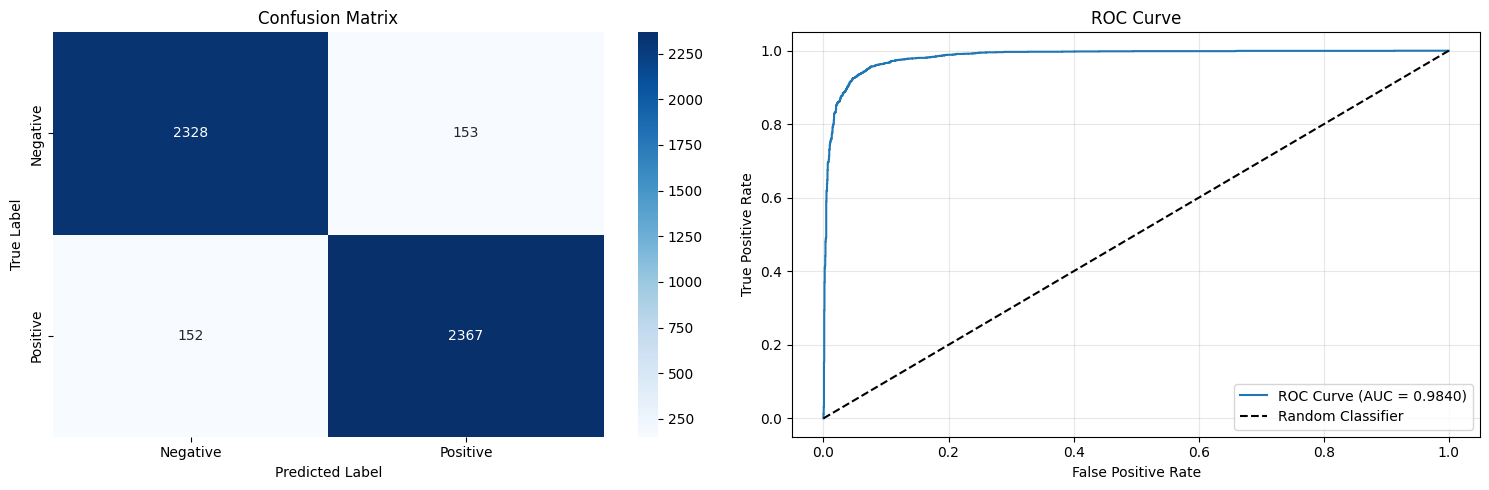


AUC-ROC Score: 0.9840


In [9]:
# ============================================================
# Evaluation: Accuracy, precision, recall, f1-score, confusion matrix and ROC curve  
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, roc_curve, roc_auc_score, 
                           precision_score, recall_score, f1_score, classification_report)
import torch.nn.functional as F

# Enhanced run_epoch to return probabilities (run model only once)
def run_epoch_with_probs(loader, train=True):
    """
    Run evaluation/training epoch and return predictions with probabilities.
    
    Args:
        loader (DataLoader): Data loader for evaluation/training.
        train (bool): Whether to run in training mode.
    
    Returns:
        tuple: Loss, accuracy, true labels, predictions, and probabilities.
    """
    model.train() if train else model.eval()
    loss_sum, preds, labels, all_logits = 0, [], [], []
    loop = tqdm(loader, leave=False)
    with torch.set_grad_enabled(train):
        for batch in loop:
            batch = {k:v.to(DEVICE) for k,v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits.detach().cpu()
            loss_sum += loss.item()*len(batch["labels"])
            preds += logits.argmax(1).tolist()
            labels += batch["labels"].cpu().tolist()
            all_logits.append(logits)
            if train:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step(); scheduler.step(); optimizer.zero_grad()
    
    # Convert logits to probabilities for positive class
    all_logits = torch.cat(all_logits, dim=0)
    probs = F.softmax(all_logits, dim=1)[:, 1].numpy()
    
    acc = accuracy_score(labels, preds)
    return loss_sum/len(loader.dataset), acc, labels, preds, probs

# Run model prediction only once to get both predictions and probabilities
_, _, true_labels, pred_labels, pred_probs = run_epoch_with_probs(test_dl, train=False)

# Print comprehensive metrics
print("Accuracy:", accuracy_score(true_labels, pred_labels))
print("Precision:", precision_score(true_labels, pred_labels, pos_label=1))
print("Recall:", recall_score(true_labels, pred_labels, pos_label=1))
print("F1-Score:", f1_score(true_labels, pred_labels, pos_label=1))
print("\nClassification Report:\n", classification_report(true_labels, pred_labels, target_names=['Negative', 'Positive']))

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 1. Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels, labels=[0, 1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=ax1)
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')
ax1.set_title("Confusion Matrix")

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)
auc_score = roc_auc_score(true_labels, pred_probs)
ax2.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')
ax2.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax2.set_xlabel("False Positive Rate")
ax2.set_ylabel("True Positive Rate")
ax2.set_title("ROC Curve")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAUC-ROC Score: {auc_score:.4f}")


**Observation: Bert surpass TF-IDF+LR about 5% on accuracy and f1 score, 0.02 on ROC AUC**

In [11]:
# ============================================================
# 5. Inspect mistakes
# ============================================================
test_df = test_df.reset_index(drop=True)
test_df["pred"]  = pred_labels
test_df["is_err"] = test_df.label != test_df.pred

# Randomly sample 3 examples from each error category
fp = test_df[(test_df.label==0) & (test_df.pred==1)].sample(n=3, random_state=42)
fn = test_df[(test_df.label==1) & (test_df.pred==0)].sample(n=3, random_state=42)

def explain(sample):
    reasons = []
    txt = sample.lower()
    if "not" in txt or "n't" in txt:
        reasons.append("heavy use of negation")
    if len(txt.split()) > 500:
        reasons.append("very long review (truncation)")
    if any(w in txt for w in ["sarcastic", "ironic"]):
        reasons.append("explicit sarcasm cues")
    if sample.count("!") > 4:
        reasons.append("excessive punctuation (tone shift)")
    return ", ".join(reasons) or "subtle sentiment / uncommon phrasing"

print("\n--- Example False Positives ---")
for i,row in fp.iterrows():
    print(f"★ [{i}] False Positive | Reason: {explain(row.review,'fp')}")
    print(row.review[:800].replace('\n',' ')+"...\n")

print("\n--- Example False Negatives ---")
for i,row in fn.iterrows():
    print(f"☆ [{i}] False Negative | Reason: {explain(row.review,'fn')}")
    print(row.review[:800].replace('\n',' ')+"...\n")


--- Example False Positives ---
★ [2478] False Positive | Reason: heavy use of negation, very long review (truncation)
It is a Frank Zappa axiom that "music journalism is people who can't write interviewing people who can't talk for people who can't read." If you ever needed proof that musicians can't talk, this is the film for you. Repeated attempts at profundity stumble over themselves to end up in monosyllabic comments delivered in awestruck voices: "Wow." (Thank you, Idris Muhammed.) This film is pretentious but, while much of the pontificating from Youssou N'Dour and his gang of merry men (and one token woman) grates, the music saves the day.The main idea behind the film (what I take to be the main idea, dredged out of the inarticulate commentary) is interesting. To gather a group of musicians from America and Europe and take them on a journey through the different styles of music that grew up in and ...

★ [2517] False Positive | Reason: heavy use of negation
"Sex and the City" 

In [13]:
# ============================================================
# 6. Retrain on the whole dataset, save model + tokenizer with timestamp
# ============================================================

# Create full dataset from all splits
full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
print(f"Full dataset size: {len(full_df)}")

# Create dataset and dataloader for the full dataset
full_ds = IMDbDS(full_df, tokenizer)
full_dl = DataLoader(full_ds, batch_size=BATCH_SIZE, shuffle=True)

# Create a fresh model for retraining on the whole dataset
all_dataset_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2)
all_dataset_model.to(DEVICE)

# Setup optimizer and scheduler for retraining (2 epochs)
RETRAIN_EPOCHS = 2
optimizer_full = AdamW(all_dataset_model.parameters(), lr=2e-5)
total_steps_full = len(full_dl) * RETRAIN_EPOCHS
scheduler_full = get_linear_schedule_with_warmup(
    optimizer_full, num_warmup_steps=0, num_training_steps=total_steps_full)

def run_epoch_full(loader, model, optimizer, scheduler, train=True):
    """
    Run a training epoch on the full dataset.
    
    Args:
        loader (DataLoader): Data loader for the full dataset.
        model: The model to train.
        optimizer: The optimizer to use.
        scheduler: The learning rate scheduler.
        train (bool): Whether to run in training mode.
    
    Returns:
        tuple: Loss and accuracy for the epoch.
    """
    model.train() if train else model.eval()
    loss_sum, preds, labels = 0, [], []
    loop = tqdm(loader, leave=False)
    with torch.set_grad_enabled(train):
        for batch in loop:
            batch = {k:v.to(DEVICE) for k,v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits.detach().cpu()
            loss_sum += loss.item()*len(batch["labels"])
            preds += logits.argmax(1).tolist()
            labels += batch["labels"].cpu().tolist()
            if train:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step(); scheduler.step(); optimizer.zero_grad()
    acc = accuracy_score(labels, preds)
    return loss_sum/len(loader.dataset), acc

print(f"\nRetraining on full dataset for {RETRAIN_EPOCHS} epochs...")
for epoch in range(1, RETRAIN_EPOCHS+1):
    tr_loss, tr_acc = run_epoch_full(full_dl, all_dataset_model, optimizer_full, scheduler_full, train=True)
    print(f"Full Dataset Epoch {epoch}: train loss {tr_loss:.3f}, acc {tr_acc:.4f}")

# Save the retrained model and tokenizer with timestamp
stamp = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
out_dir = f"distilbert_imdb_full_{stamp}"
all_dataset_model.save_pretrained(out_dir)
tokenizer.save_pretrained(out_dir)
print(f"\nModel & tokenizer saved to ./{out_dir}")

Full dataset size: 50000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Retraining on full dataset for 2 epochs...


Full Dataset Epoch 1: train loss 0.232, acc 0.9108


Full Dataset Epoch 2: train loss 0.129, acc 0.9603

Model & tokenizer saved to ./distilbert_imdb_full_20250615_225839
